In [74]:
!pwd

/home/t/writhe


In [71]:
import numpy as np
import matplotlib.pyplot as plt
import writhe_tools
from writhe_tools import utils
from writhe_tools.utils import (load_dict,
                                load_dict,
                                lsdir,
                                num_str,
                                load_array_dir,
                                symbols,
                                group_by, indices_stat,
                                make_index_function,
                                reindex_list
                               )

from writhe_tools.plots import fes2d, subplots_fes2d, proj2d, subplots_proj2d
from writhe_tools.stats import rotate_points
from writhe_tools import plots
from cycler import cycler
from writhe_tools.utils import save_dict
from writhe_tools.msm_tools import (MarkovModel,
                                    reindex_dtraj,
                                    reindex_matrix,
                                   )
from writhe_tools.writhe import Writhe
from writhe_tools.stats import Kmeans
#import pyemma
import deeptime
from copy import deepcopy
from functools import partial
from scipy.stats import bootstrap

def longest_timescale(dtraj, lagtime):
    # deal with failing models during parameter scans
    try:
        return deeptime.markov.msm.MaximumLikelihoodMSM(reversible=True).fit_fetch(dtraj, lagtime=lagtime).timescales(1).item()
    except:
        return np.nan

def iter_longest_timescale(dtraj, lagtimes = np.arange(5, 550, 50)):
    return np.array([longest_timescale(dtraj, lag) for lag in lagtimes])

# split individual trajectories from concatenated ab42 trajectories
lengths = np.load(*lsdir("/data/writhe/ab42", keyword="lengths"))
split = np.cumsum(lengths)[:-1]

Text(-0.02, 0.5, 'Kinetic Variance')

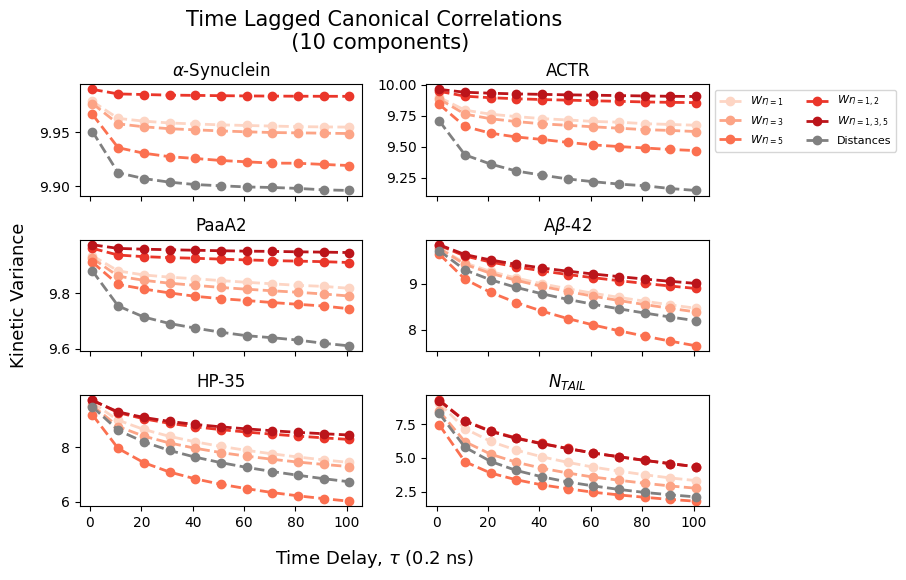

In [38]:
paths=["/home/t/writhe/asyn/full/apo/data/tcca/",
       "/home/t/writhe/actr/data/tcca/",
       "/data/writhe/paaa2/tcca/",
       "/data/writhe/ab42/tcca/",
       "/home/t/writhe/hp35/data/tcca/",
       "/home/t/writhe/ntail/data/tcca/",
       ]

proteins = ["asyn", "actr", "paaa2", "ab42", "hp35", "ntail"]

tcca_scores = {i : dict(path=j) for i,j in zip(proteins, paths)}

names = [r"$\alpha$-Synuclein", "ACTR", "PaaA2", r"A$\beta$-42", "HP-35", r"$N_{TAIL}$"]

keyword = ["val", "npy"]           
formatter = lambda k : k if int(k) <= 10 else ",".join(str(k))
file_to_key = lambda k : formatter(utils.num_str(utils.rm_path(k), return_str=False))
load = lambda x : np.load(x)[:10] # compute vamp score with dimension 10

for key, value in tcca_scores.items():
            
    #writhe
    value.update({file_to_key(dir): load_array_dir(dir, keyword=keyword, stack=True, load=load )
                 for dir in lsdir(value["path"]+"writhe", keyword="length")})
    #distances
    value.update(dict(distances=load_array_dir(value["path"]+"distances", keyword=keyword, stack = True)))



fig, axes = plt.subplots(3,2,figsize=(7,5),sharey=False, sharex=True)
for ax, name,  (key, value) in zip(axes.flat, names, tcca_scores.items()):
    
    ax.set_prop_cycle((cycler(color=writhe_tools.plots.get_color_list(5,
                                                             "Reds",
                                                              trunc=50,
                                                              pre_trunc=40))))
    ax.set_title(name)
    
    if name == r"$\alpha$-Synuclein":
        ax.yaxis.set_major_formatter('{x:.2f}')

    for k, v in value.items():
        
        if k not in [1, 3, 5, "1,2", "1,3,5", "distances"]: continue # pickout the data we want to look at
        
        
        elif k in [1, 3, 5, "1,2", "1,3,5"]:
            
            if len(v) != 11: #account for the fact that some datasets include scores for tau=5 steps
                v = np.delete(v, 1, axis=0)

            ax.plot(np.arange(1, 111, 10).astype(int),
                    (v[:,:10]**2).sum(-1),
                    label=f"$Wr$$_{{l={k}}}$",
                    lw=2,
                    ls="--",
                    marker="o")
                #ax.legend(bbox_to_anchor=[1,1], fontsize=8)
        
        elif k == "distances":
            
            if len(v) != 11: #account for the fact that some datasets include scores for tau=5 steps
                v = np.delete(v, 1, axis=0)
                
            ax.plot(np.arange(1, 111, 10).astype(int),
                    (v[:,:10]**2).sum(-1),
                    label="Distances",
                    lw=2,
                    ls="--",
                    marker="o",
                    color="gray")
        else: continue
        #ax.set_xticks(np.linspace(1,111,11), labels=)

fig.tight_layout()
axes[0,-1].legend(bbox_to_anchor=[1,1],
                  fontsize=8, ncol=2)
fig.supxlabel(r"Time Delay, $\tau$ (0.2 ns)", y=-0.05, fontsize=13)

fig.suptitle("Time Lagged Canonical Correlations\n  (10 components)",
             fontsize=15,y=1.07)

fig.supylabel("Kinetic Variance",
              y=0.5,x=-0.02, fontsize=13)


#plt.savefig("/home/t/writhe/tcca_comp_fig.png", dpi=1300, bbox_inches="tight")


In [39]:
# select most illustrative projections
tcca_projections = {key:{} for key in tcca_scores.keys()}
lengths = [1, 1, 135, 135, 13, 12345]
lags = [21, 31, 31, 11, 31, 11]

for length, lag, value, path in zip(lengths, lags, tcca_projections.values(), paths):
    
    kws = [f"lag_{lag}", "proj"]
    
    value["writhe"] = load_array_dir(lsdir(f"{path}writhe", str(length))[0],
                                     kws,
                                     stack=True).squeeze()
    
    value["distances"] = load_array_dir(f"{path}distances", kws, stack=True).squeeze()

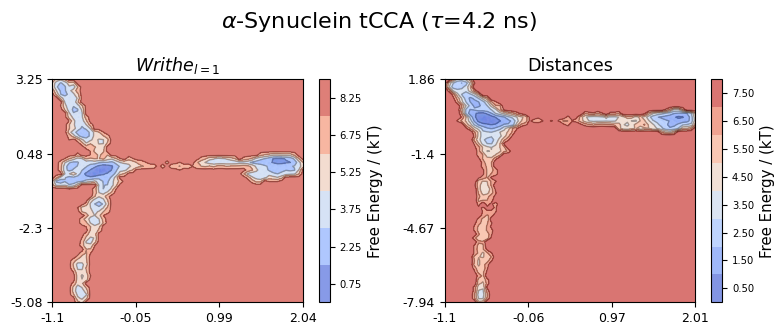

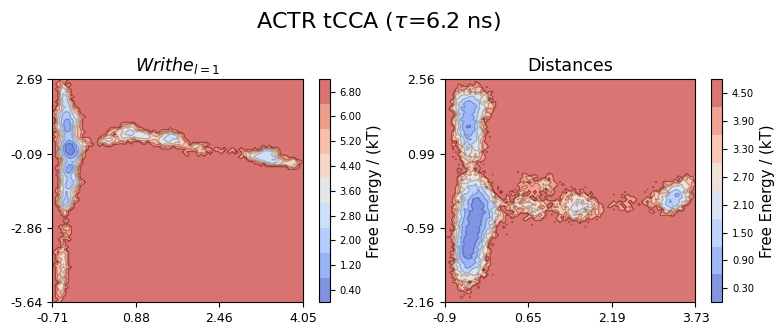

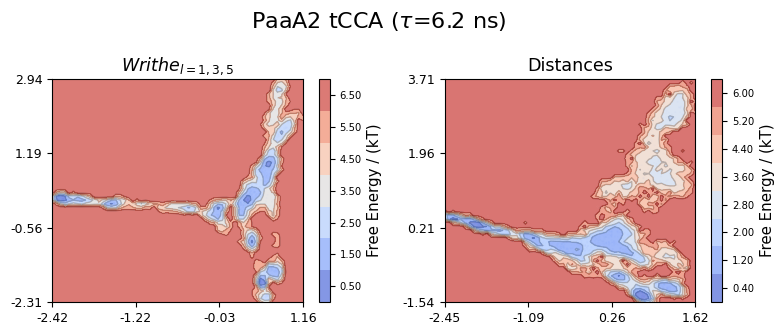

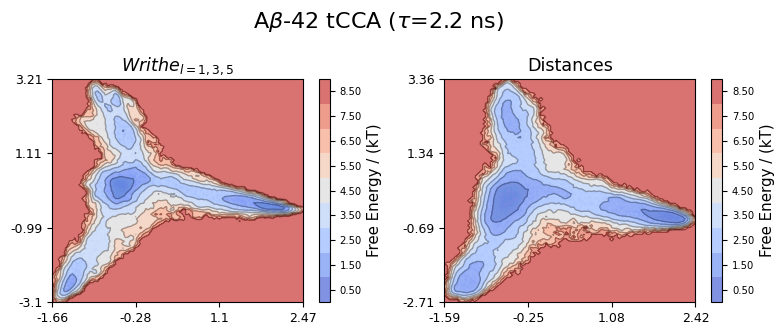

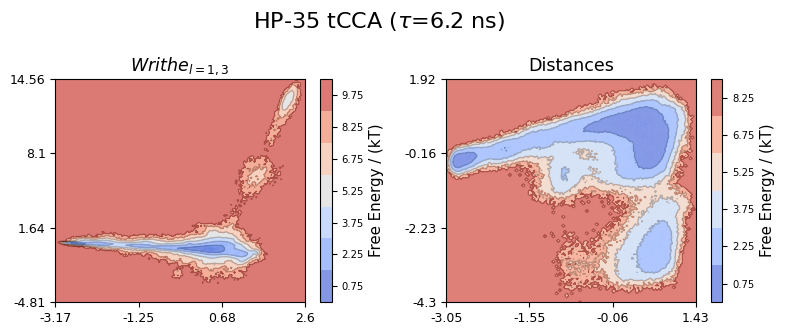

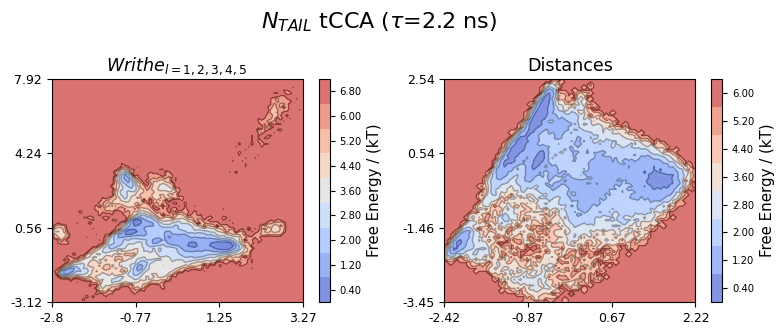

In [40]:
args = dict(mask=False,
            bins=100,
            n_contours=7,
            contour_lines=True,
            alpha_lines=0.4,
            alpha_contours=.7,
            cmap="coolwarm",
            scatter=True,
            scatter_alpha=0.15,
            scatter_cmap="coolwarm_r",
            scatter_min=.86,
            scatter_max=.5,
            scatter_size=0.02
        
            )

for value, name, l, tau, bins, countours, alpha_contours, scatter_scale in\
zip(tcca_projections.values(),
    names,
    lengths,
    lags,
    [60, 90, 60, 100, 150, 80],
    [7, 8, 7, 9, 6, 8],
    [.3,.2,.2,.3,.2,.3],
    [1, .8, .8, 7,1,1]
   ):
    args["bins"] = bins
    args["scatter_stride"] = int(len(value["writhe"][:,:2]*1.5) / (scatter_scale * 1000))
    args["n_contours"] = countours
    args["alpha_lines"]=alpha_contours  
    fig, axes = plt.subplots(1, 2, figsize=(8,3))
    ax = axes.flat    
    l = str(l)
    fes2d(value["writhe"][:,:2],
          ax=ax[0],
          font_scale=.9,
          title=f"$Writhe$$_{{l={','.join(l) if len(l) > 1 else l}}}$",
          **args)
    
    fes2d(rotate_points(value["writhe"][:,:2], value["distances"][:,:2]),
          ax=ax[1],
          font_scale=.9,
          title="Distances",
          **args
         )
    
    fig.tight_layout()
    fig.suptitle(name + f" tCCA (${symbols('tau')}$={tau *.2 :.1f} ns)", x=.48, y = 1.10,size=16)
    plt.savefig(f"./{name}_projection_plot", dpi=1200, bbox_inches="tight")

In [42]:
# select projections that give the best MSMs
tcca_projections = {key:{} for key in tcca_scores.keys()}
lengths = [1, 135, 135, 135, 13, 12345]
lags = [21, 31, 31, 11, 31, 11]

for length, lag, value, path in zip(lengths, lags, tcca_projections.values(), paths):
    
    kws = [f"lag_{lag}", "proj"]
    
    value["writhe"] = load_array_dir(lsdir(f"{path}writhe",
                                           str(length))[0],
                                     kws,
                                     stack=True).squeeze()
    
    value["distances"] = load_array_dir(f"{path}distances", kws, stack=True).squeeze()

asyn
actr
paaa2
ab42
hp35
ntail


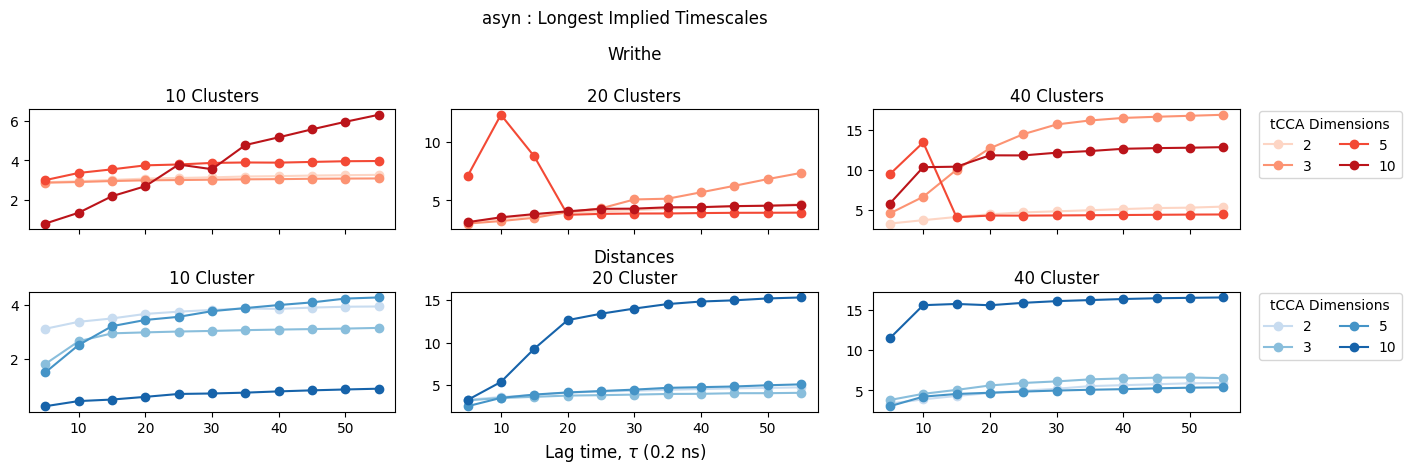

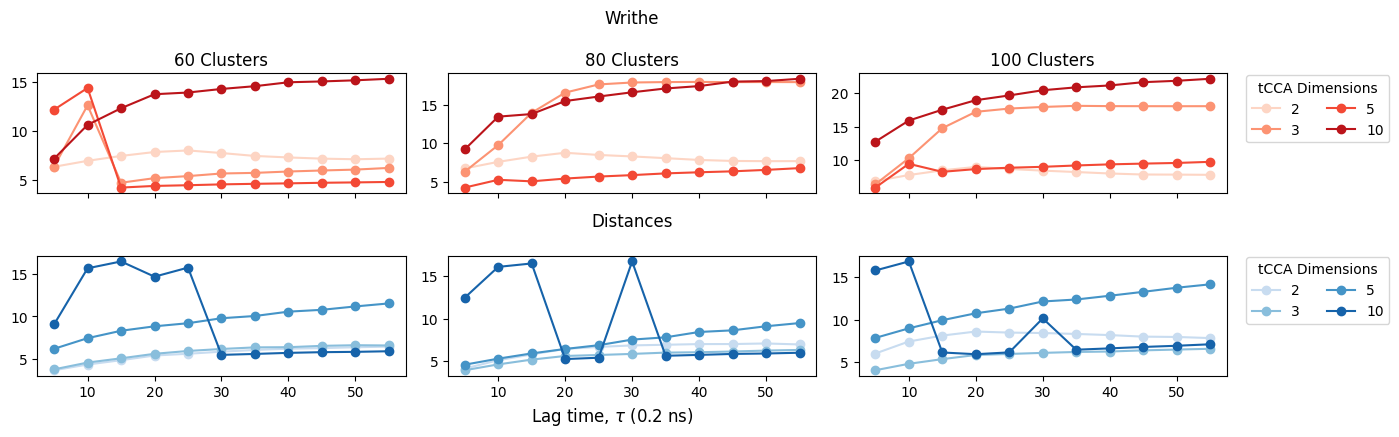

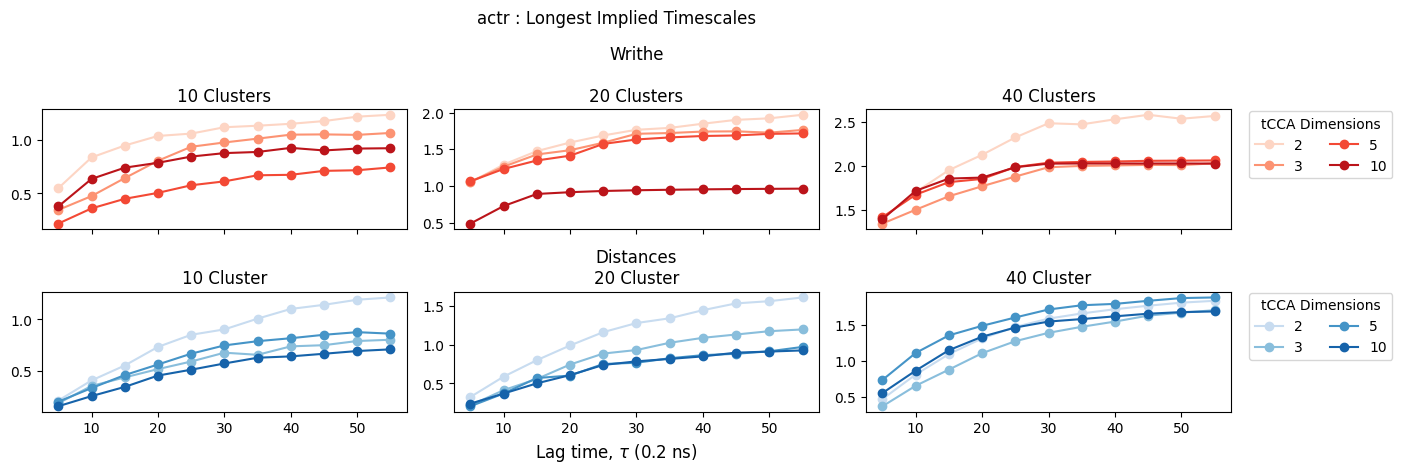

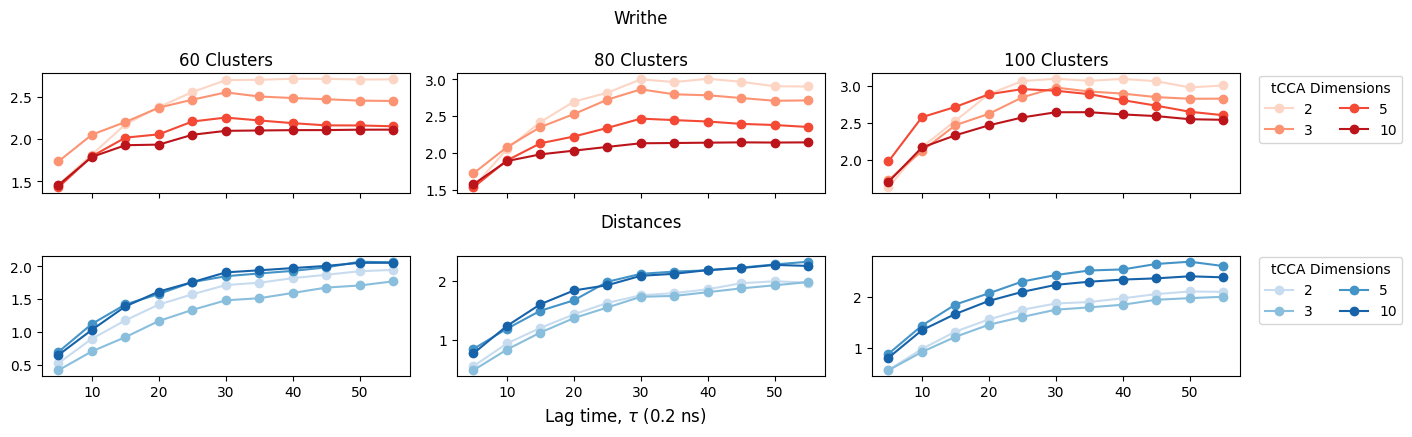

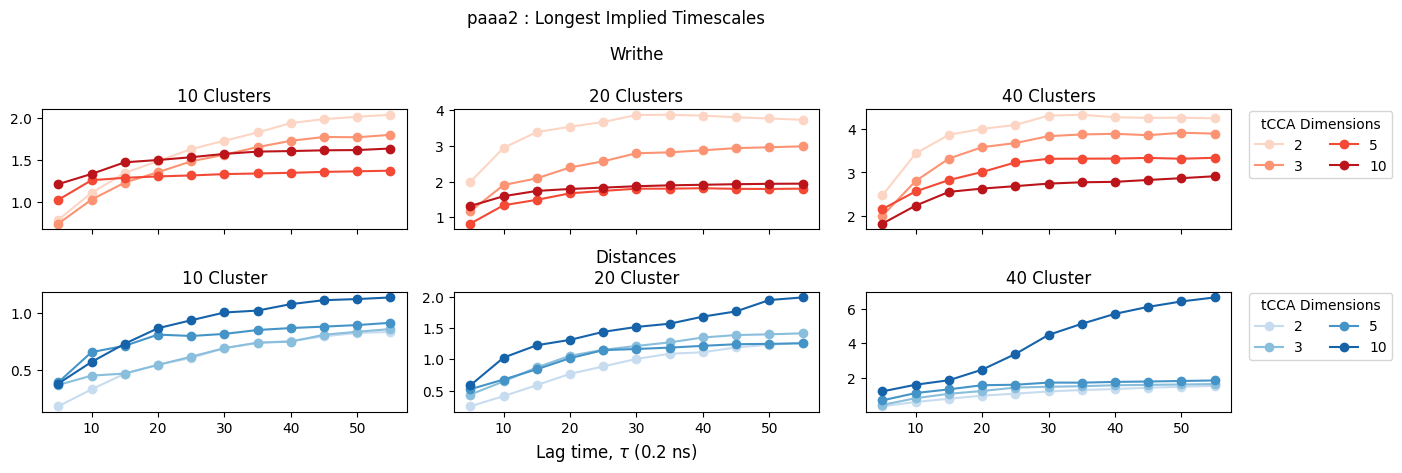

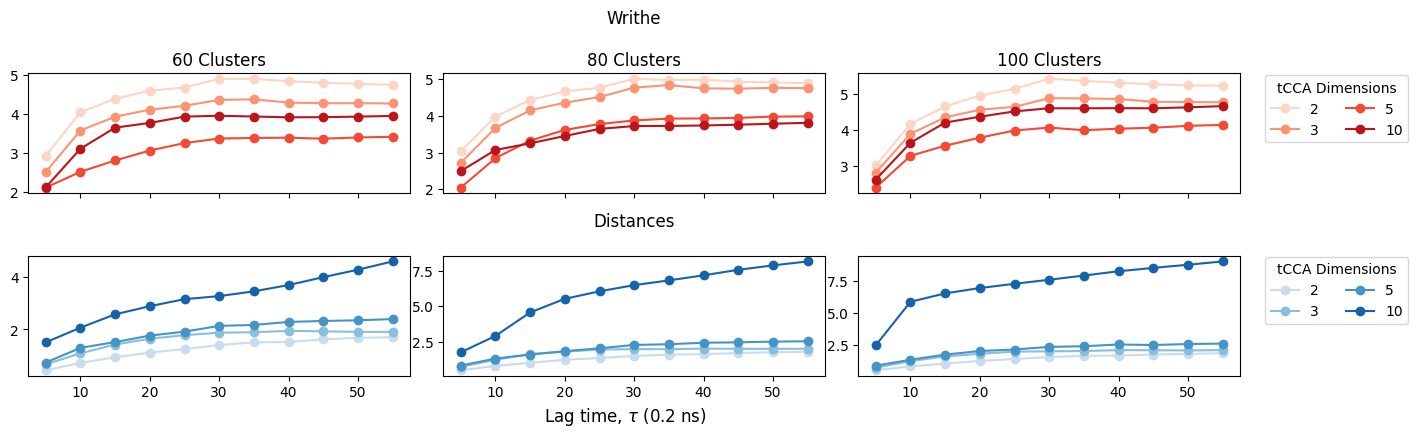

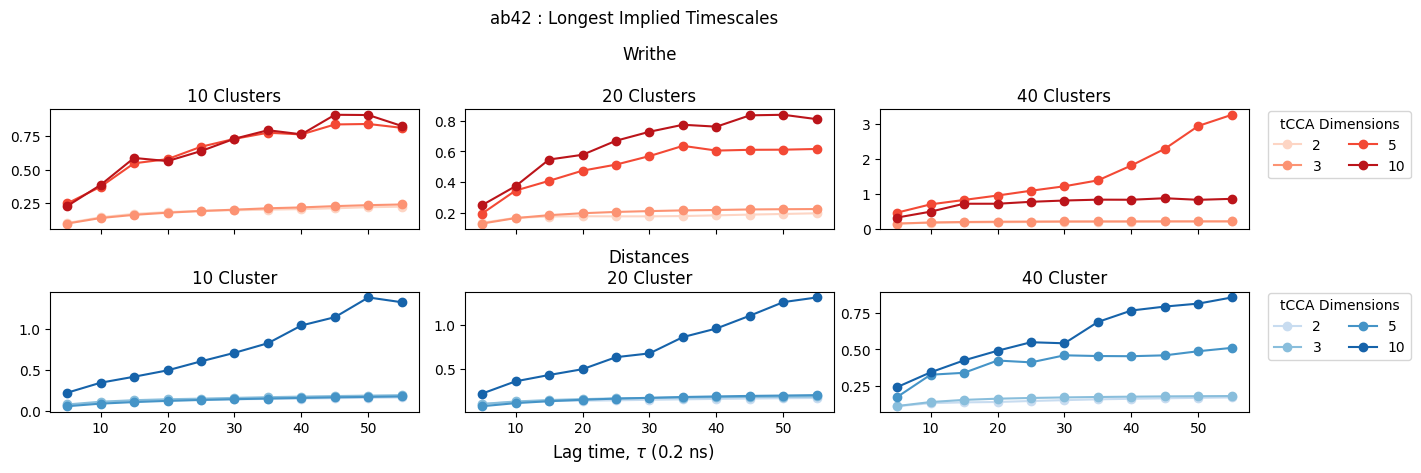

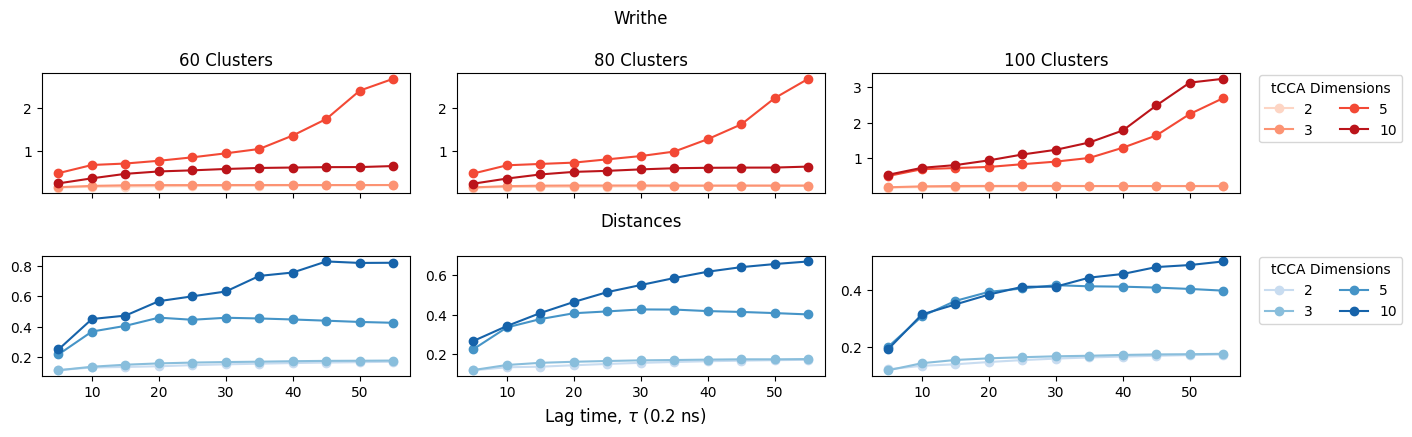

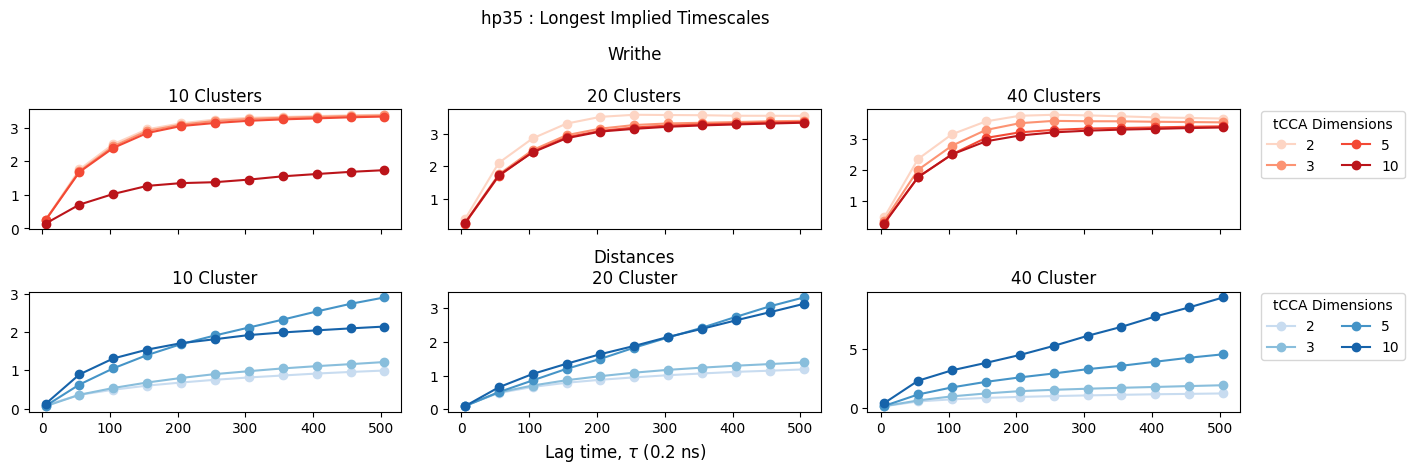

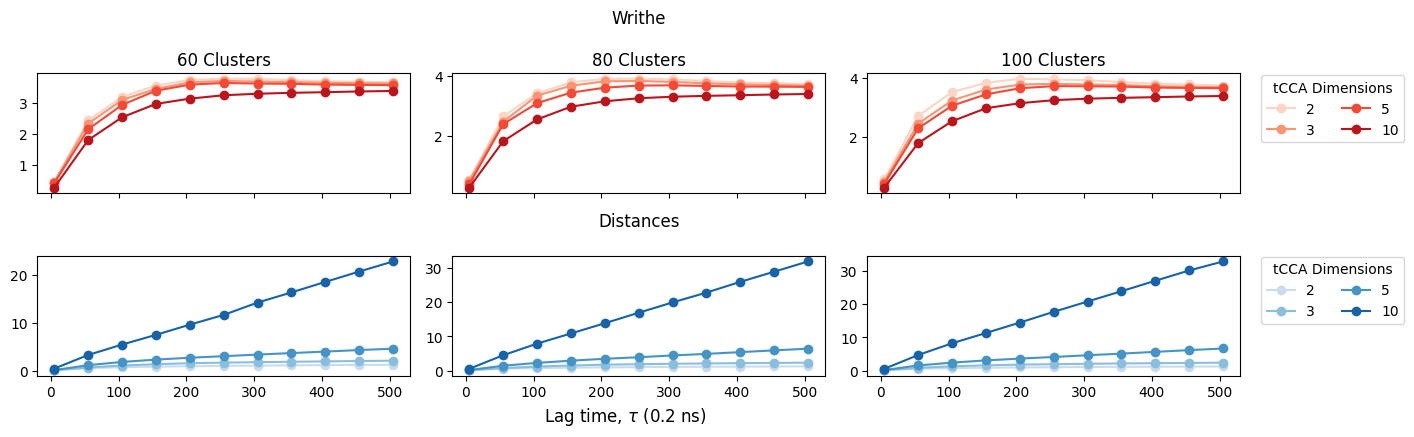

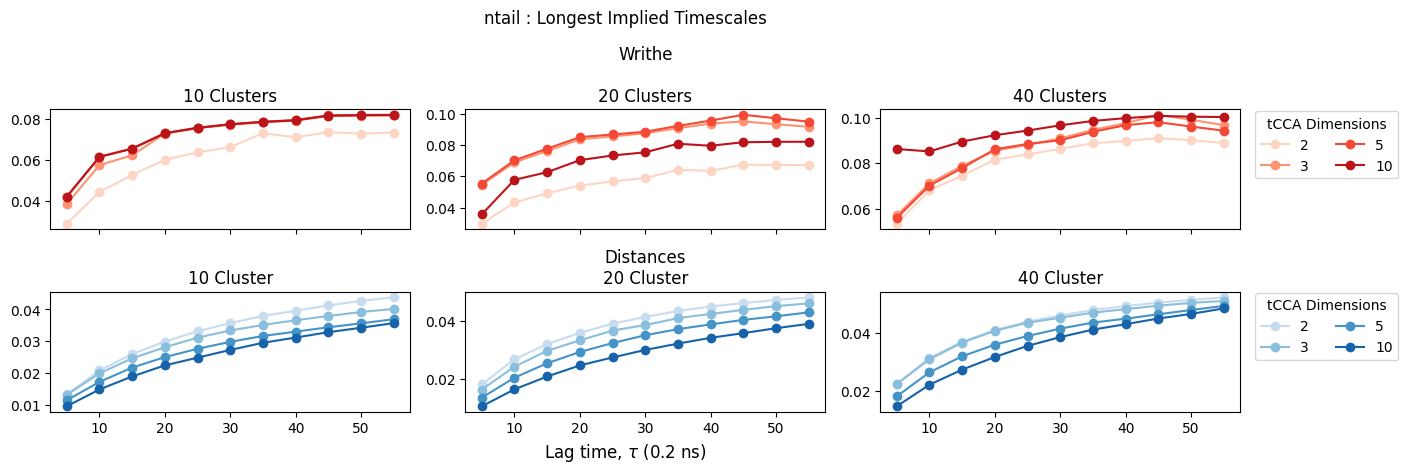

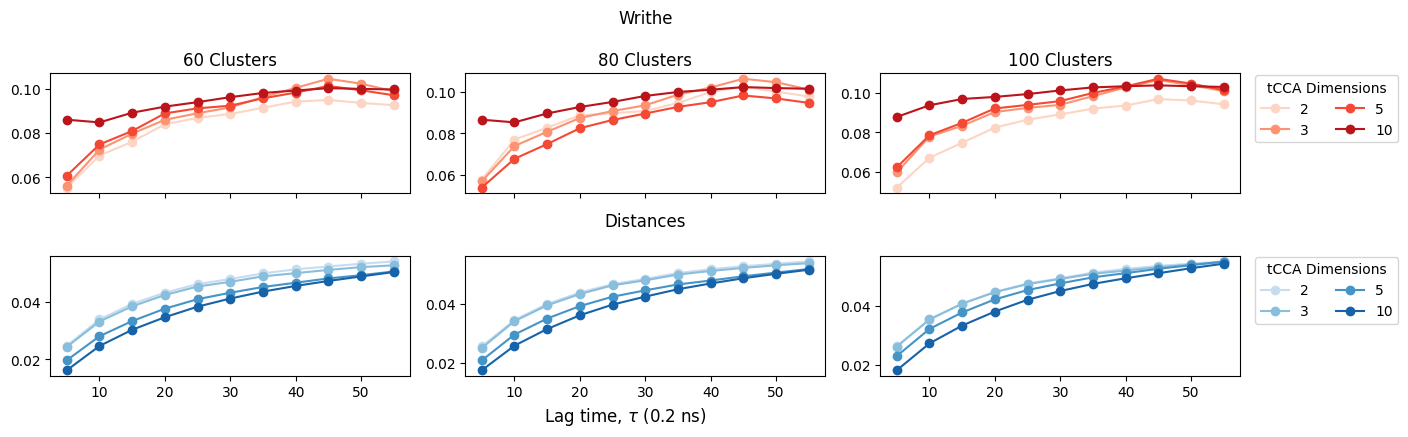

In [73]:
#steps = np.arange(5, 550, 50) # all other datasets - np.arange(1, 12) * 5
for key in proteins:
    steps = np.arange(1, 12) * 5 if key != 'hp35' else np.arange(5, 550, 50)
    ks = [10, 20 , 40]# 60, 80]# 60]#, 80, 100] # number of clusters
    ds = [2, 3, 5, 10] #8, 10] # number of dimensions
    fig, axes = plt.subplots(2, len(ks), figsize=(len(ks) * 4.2, 2.8 * 1.5), sharex=True, sharey=False)
    print(key)

    #steps = np.arange(1, 12) * 5
    for k, ax in zip(ks, axes.T):

        ax[0].set_prop_cycle((cycler(color=writhe_tools.plots.get_color_list(len(ds),
                                                             "Reds",
                                                              trunc=50,
                                                              pre_trunc=40))))

        ax[1].set_prop_cycle((cycler(color=writhe_tools.plots.get_color_list(len(ds),
                                                         "Blues",
                                                          trunc=50,
                                                          pre_trunc=60))))
        
        ax[0].set_title(("Writhe\n\n" if k==20 else "") + f"{k} Clusters")
        ax[1].set_title(("Distances\n" if k==20 else "") + f"{k} Cluster")



        for d in ds:

            dtraj = [Kmeans(tcca_projections[key][i], k, d)[0] for i in "writhe,distances".split(",")]

            if key == "ab42":
                
                dtraj = [np.split(i, split) for i in dtraj] # this appears to run over all datasets considered for a particular system
            
            try:
                timescale = [iter_longest_timescale(i, lagtimes=steps) for i in dtraj]
                #print("did something good")
                #print(timescale)
            except: 
                print(f"Estimation failed for clusters : {k}, dim : {d}")
                continue

            ax[0].plot(steps, 
                       timescale[0] * 1e-3 * 0.2, #convert to microseconds
                     #color='indianred',
                     label=d,
                     marker="o")

            ax[1].plot(steps, timescale[1] * 1e-3 * 0.2, #convert to microseconds
                     #color="gray",
                     label=d,
                     marker="o")
            #break


    # plt.ylabel(r"ITS ($\mu$s)")
    # plt.legend()
    fig.tight_layout()
    ax[0].legend(bbox_to_anchor=[1.46,1.04], ncol=2, title="tCCA Dimensions")
    ax[1].legend(bbox_to_anchor=[1.46,1.05], ncol=2, title="tCCA Dimensions")
    fig.suptitle(f"{key} : Longest Implied Timescales", y=1.05)
    fig.supxlabel(r"Lag time, $\tau$ (0.2 ns)", y=-0.03)


    ks = [60, 80, 100]# 60, 80]# 60]#, 80, 100]
    ds = [2, 3, 5, 10] #8, 10]

    fig, axes = plt.subplots(2, len(ks), figsize=(len(ks) * 4.2, 2.8 * 1.5), sharex=True, sharey=False)

    
    for k, ax in zip(ks, axes.T):

        ax[0].set_prop_cycle((cycler(color=writhe_tools.plots.get_color_list(len(ds),
                                                             "Reds",
                                                              trunc=50,
                                                              pre_trunc=40))))

        ax[1].set_prop_cycle((cycler(color=writhe_tools.plots.get_color_list(len(ds),
                                                         "Blues",
                                                          trunc=50,
                                                          pre_trunc=60))))
        ax[0].set_title(("Writhe\n\n" if k==80 else "") + f"{k} Clusters")
        ax[1].set_title("Distances\n" if k==80 else "")



        for d in ds:

            dtraj = [Kmeans(tcca_projections[key][i], k, d)[0] for i in "writhe,distances".split(",")]
            
            if key == "ab42":
                
                dtraj = [np.split(i, split) for i in dtraj]
            try:
                timescale = [iter_longest_timescale(i, lagtimes=steps) for i in dtraj]
                #print(timescale)
            except: 
                print(f"Estimation failed for clusters : {k}, dim : {d}")
                continue

            ax[0].plot(steps, timescale[0] * 1e-3 * 0.2, #convert to microseconds
                     #color='indianred',
                     label=d,
                     marker="o")

            ax[1].plot(steps, timescale[1] * 1e-3 * 0.2, #convert to microseconds
                     #color="gray",
                     label=d,
                     marker="o")


    # plt.ylabel(r"ITS ($\mu$s)")
    # plt.legend()
    fig.tight_layout()
    ax[0].legend(bbox_to_anchor=[1.46,1.04], ncol=2, title="tCCA Dimensions")
    ax[1].legend(bbox_to_anchor=[1.46,1.05], ncol=2, title="tCCA Dimensions")
    #fig.suptitle("Longest Implied Timescales", y=1.05)
    fig.supxlabel(r"Lag time, $\tau$ (0.2 ns)", y=-0.03)
